In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

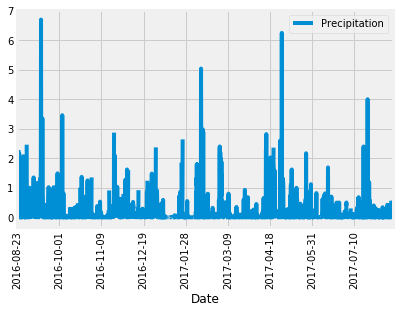

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


# Calculate the date 1 year ago from the last data point in the database
lastyear = dt.date(2017,8,23)-dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= lastyear).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])
df.set_index(df['Date'],inplace = True)

# Sort the dataframe by date
df = df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(rot = 90)


![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [12]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

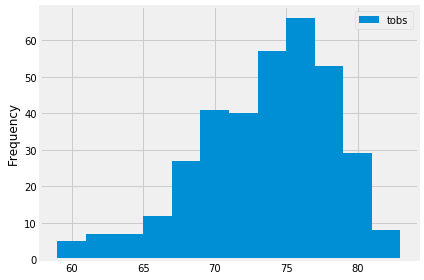

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.tobs).\
filter(Measurement.station == 'USC00519281').\
filter(Measurement.date >= lastyear).all()

tempobs = pd.DataFrame(results, columns=['tobs'])
tempobs.plot.hist(bins = 12)

plt.tight_layout()

![precipitation](Images/station-histogram.png)

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
yearstart = dt.date(2018,1,1)-dt.timedelta(days=365)
yearend = dt.date(2018,1,7)-dt.timedelta(days=365)
tmin, tavg, tmax = calc_temps(yearstart.strftime("%Y-%m-%d"),yearend.strftime("%Y-%m-%d"))[0]
print(tmin, tavg, tmax)

62.0 68.36585365853658 74.0


[(62.0, 68.36585365853658, 74.0)]

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


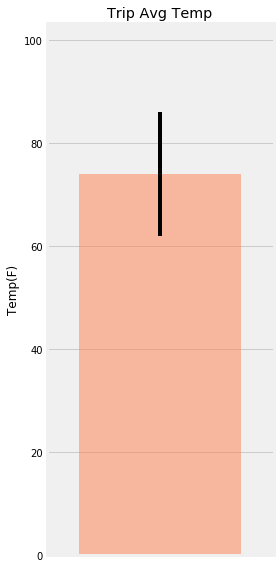

In [27]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
from pandas.plotting import table 

fig,ax=plt.subplots(figsize = plt.figaspect(2.))
xpos = 1 
yerror = tmax - tmin 

bar = ax.bar(xpos, tmax, yerr = yerror, alpha =.5, color = 'coral', align = 'center')
ax.set(xticks = range(xpos),xticklabels = 'a', title = 'Trip Avg Temp', ylabel = 'Temp(F)')
ax.margins(.2,.2)
fig.tight_layout()

fig.show()

In [54]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
select = [Station.station, Station.name, func.sum(Measurement.prcp), Station.latitude, Station.longitude, Station.elevation]

results = (session.query(*select).\
           filter(Station.station == Measurement.station).\
           filter(Measurement.date >= yearstart).\
           filter(Measurement.date <= yearend).\
           group_by(Station.station).order_by(func.sum(Measurement.prcp).desc()).all())

print(results)


[('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 0.61, 21.33556, -157.71139, 19.5), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 0.6, 21.5213, -157.8374, 7.0), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 0.6, 21.3331, -157.8025, 152.4), ('USC00513117', 'KANEOHE 838.1, HI US', 0.35, 21.4234, -157.8015, 14.6), ('USC00519281', 'WAIHEE 837.5, HI US', 0.2, 21.45167, -157.84888999999998, 32.9), ('USC00519397', 'WAIKIKI 717.2, HI US', 0.0, 21.2716, -157.8168, 3.0)]


## Optional Challenge Assignment

In [55]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [60]:

# Set the start and end date of the trip
start = "2018-07-01"
end = "2018-07-15"
# push each tuple of calculations into a list called `normals`
startnum = int(start[-2:])
endnum = int(end[-2:])
tripLength = endnum - startnum + 1

# Use the start and end date to create a range of dates
start = dt.datetime.strptime(start, '%Y-%m-%d')
# Stip off the year and save a list of %m-%d strings


dateList = [dt.datetime.strftime(start + dt.timedelta(days = x), '%m-%d') 
            for x in range(0, tripLength)]
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [daily_normals(date) for date in dateList]

# calculate the daily normals for your trip
normals


[[(67.0, 74.77777777777777, 81.0)],
 [(68.0, 75.40384615384616, 82.0)],
 [(68.0, 75.32075471698113, 87.0)],
 [(70.0, 76.57142857142857, 81.0)],
 [(66.0, 75.0, 81.0)],
 [(69.0, 75.0, 81.0)],
 [(69.0, 74.91071428571429, 82.0)],
 [(69.0, 76.08333333333333, 83.0)],
 [(68.0, 76.19298245614036, 83.0)],
 [(68.0, 75.62068965517241, 82.0)],
 [(70.0, 75.78947368421052, 81.0)],
 [(67.0, 75.96491228070175, 82.0)],
 [(69.0, 76.1896551724138, 81.0)],
 [(61.0, 76.2280701754386, 82.0)],
 [(68.0, 76.2542372881356, 82.0)]]

In [65]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals = [np.array(normal[0]) for normal in normals]
normalstable = pd.DataFrame(normals)
dateList = normalstable["Date"]
normalstable = normalstable.set_index("Date")
normalstable = normalstable.rename(columns={0: "Low Temp", 1: "Avg Temp", 2: "High Temp"})

normalstable

IndexError: too many indices for array

In [62]:
# Plot the daily normals as an area plot with `stacked=False`
x = [1, 2, 3, 4, 5]
y1 = [1, 1, 2, 3, 5]
y2 = [0, 4, 2, 6, 8]
y3 = [1, 3, 5, 7, 9]

y = np.vstack([y1, y2, y3])

labels = ["Fibonacci ", "Evens", "Odds"]

fig, ax = plt.subplots()
ax.stackplot(x, y1, y2, y3, labels=labels)
ax.legend(loc='upper left')
plt.show()

fig, ax = plt.subplots()
ax.stackplot(x, y)
plt.show()